### ROB 537 HW4: Learning-Based Control

1) Create a Q-learning agent that learns to solve the "Cart Pole" environment. The agent should balance the pole for 100 time steps.

    How will you handle the continuous state space?

 

2) Evolve a neural network to solve the previous task.

    What will you use for your evaluation function?

    What mapping should the network learn?

 

Evaluate & report the following:

- Answers to previous questions
- Performance over time curves for each experiment. 
- A description of your algorithms.
- Similarities and differences in performance for the two algorithms + an explanation.
 

 

Extra-Credit Bonus: Use these two learning methods to solve another gym task. Choose your favorite environment from either the "Classic Control" or "Box2D" sets.

- What environment did you choose?
- What changes did you have to make to adapt your learning algorithms to this new environment?

In [493]:
# Imports
import gymnasium as gym
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import random
from collections import defaultdict, deque
import copy

import matplotlib.pyplot as plt

from tqdm import tqdm

from time import sleep

#### Part 1: Solved with DQN

Define DQN Agent

In [533]:
"""Agent Class based off BlackjackAgent from https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/"""

"""
Modified to make into DQN using following references:
- https://blog.gofynd.com/building-a-deep-q-network-in-pytorch-fa1086aa5435 - cartpole-specific (beefed-up)
- https://gibberblot.github.io/rl-notes/single-agent/function-approximation.html - example using street crossing thing

"""

#TODO: This should work for regular Q-Learning, now make into DQN


class DQN_CartPole_Agent:

    """Generate new DQN_CartPole_Agent in environment env, with training params"""
    """Also initializes q_network"""
    def __init__(
                self,
                env,
                initial_epsilon: float,
                epsilon_decay: float,
                final_epsilon: float,
                sync_freq,
                exp_replay_size,
                discount_factor: float=0.95,
                hidden_dim=64,
                alpha=0.001,
            ):
        
        self.env = env

        self.discount_factor = torch.tensor(discount_factor) # gamma -  self.gamma = torch.tensor(0.95).float()

        # epsilon-greedy values
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # == NNs Setup ==
       
        # initialize NN # from gibberblot.github.io
        # this network is trained to output 
        # q_network takes in a state as input and returns list of Q vals for all actions available from that state
        self.q_network = nn.Sequential(
            nn.Linear(in_features=self.env.observation_space.shape[0], out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=self.env.action_space.n)
        )
        #self.loss_fn = nn.MSELoss()
        self.optimizer = Adam(self.q_network.parameters(), lr=alpha)

        # == Second NN "Target Network" to increase training stability ==
        # See [1]
        self.target_network = copy.deepcopy(self.q_network)

        # for synchronizing target with q_network
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0

        # == Replay buffer to address catastrophic forgetting ==
        # "The agent will gather the experience in replay buffer and then a random batch of experience will be sampled from this buffer. [1]"
        self.experience_replay = deque(maxlen = exp_replay_size)


    """ Returns the best action with probability (1 - epsilon), otherwise return random action """
    def get_action(self, obs) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploitation)
        else:
            with torch.no_grad():
                Q_vals = self.q_network(torch.tensor(obs).float())
            Q_max, action = torch.max(Q_vals, dim=0)
            return action.item()
        
    """Returns next Q, for max s,a"""
    # We never want to train target network, only update periodically to match q_net
    #def get_q_next(self, obs):
    #    with torch.no_grad():
    #        Q_vals_next = self.target_network(torch.tensor(obs).float())
    #    #Q_max_next, action = torch.max(Q_vals_next, dim=1)
    #    return Q_vals_next

    """Add experience to replay buffer"""
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    """Extract experience"""
    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)

        sample = random.sample(self.experience_replay, sample_size)

        obs = [exp[0] for exp in sample]
        action = [exp[1] for exp in sample]
        rew = [exp[2] for exp in sample]
        obs_next = [exp[3] for exp in sample]
        terminated = [exp[4] for exp in sample]
        
        return obs, action, rew, obs_next, terminated


    """In train() function, the Q-value of the current state is estimated 
    using Main Q-Network. The Q-value of the next state is calculated using 
    Target Network, which is then used to calculate the target return.
    - from blog.gofynd.com article"""
    """Training architecture adapted from: https://stackoverflow.com/questions/56964657/cartpole-v0-loss-increasing-using-dqn"""
    def train(self, batch_size):

        obs, action, reward, obs_next, terminate = self.sample_from_experience(sample_size = batch_size)

        state_batch = torch.Tensor(obs)
        action_batch = torch.LongTensor(action).unsqueeze(1)
        reward_batch = torch.Tensor(reward)
        next_state_batch = torch.Tensor(obs_next)
        done_batch = terminate

        pred_q = self.q_network(state_batch).gather(1, action_batch)

        next_state_q_vals = torch.zeros(batch_size)

        for idx, next_state in enumerate(next_state_batch):
            if done_batch[idx] == True: # if failed, then less reward
                next_state_q_vals[idx] = -1
            else:
                # .max in pytorch returns (values, idx), we only want vals
                #next_state_q_vals[idx] = self.get_q_next(next_state_batch[idx]).max(0)[0]
                next_state_q_vals[idx] = self.target_network(next_state_batch[idx]).max(0)[0] #.detach()

        better_pred = (reward_batch + next_state_q_vals).unsqueeze(1)

        torch.set_grad_enabled(True)

        loss = nn.functional.smooth_l1_loss(pred_q, better_pred) #MSELoss(pred_q, better_pred)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()

    """Synchronize target and q networks"""
    def sync_networks(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    """Call during training to decrease probability of exploration over time"""
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Define (or do?) Training & Validation

In [534]:
EPISODES = 10000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (EPISODES/1.5)
final_epsilon = 0.05
sync_freq = 1000
exp_replay_size = 60000

# Init environment & agent
env = gym.make('CartPole-v1')
dqn_agent = DQN_CartPole_Agent(env, start_epsilon, epsilon_decay, final_epsilon, sync_freq, exp_replay_size, alpha = 0.0001)

# == Fill replay buffer to capacity ==
# Full exploration at this time - no epsilon decay
index = 0
for a in range(exp_replay_size):
    obs, info = env.reset()
    done = False
    while not done:
        action = dqn_agent.get_action(obs)
        obs_next, reward_gained, done, truncated, info = env.step(action)
        dqn_agent.collect_experience([obs, action, reward_gained, obs_next, done])
        
        obs = obs_next

        # timeout tracker
        index += 1
        if index > exp_replay_size:
            break


# === MAIN TRAINING ===
index = exp_replay_size / 2

# Performance trackers
track_loss = []
track_reward = []
track_episode_len = []
track_epsilon = []

for a in tqdm(range(EPISODES)):
    obs, info = env.reset()
    done = False
    truncated = False
    reward_gained = 0
    losses = 0
    episode_len = 0

    # periodically synchronize networks
    if a % sync_freq == 0:
        dqn_agent.sync_networks()

    while not done and not truncated:
        
        # Make action, collect reward
        action = dqn_agent.get_action(obs)
            
        obs_next, reward, done, truncated, info = env.step(action)
        dqn_agent.collect_experience([obs, action, reward, obs_next, done])

        # Update bookkeeping
        obs = obs_next
        reward_gained += reward
        episode_len += 1
        index += 1

        # Agent interacts with environment & fills experience into buffer
        # then periodically trains by sampling this experience here
        if index > 128:
            index = 0

            # do training steps, training on randomly sampled batches
            for j in range(4):
                loss = dqn_agent.train(128)
                losses += loss

    dqn_agent.decay_epsilon()

    # Performance tracking
    track_loss.append(losses/episode_len)
    track_reward.append(reward_gained)
    track_episode_len.append(episode_len)
    track_epsilon.append(dqn_agent.epsilon)


100%|██████████| 10000/10000 [1:21:10<00:00,  2.05it/s]


Evaluate Results

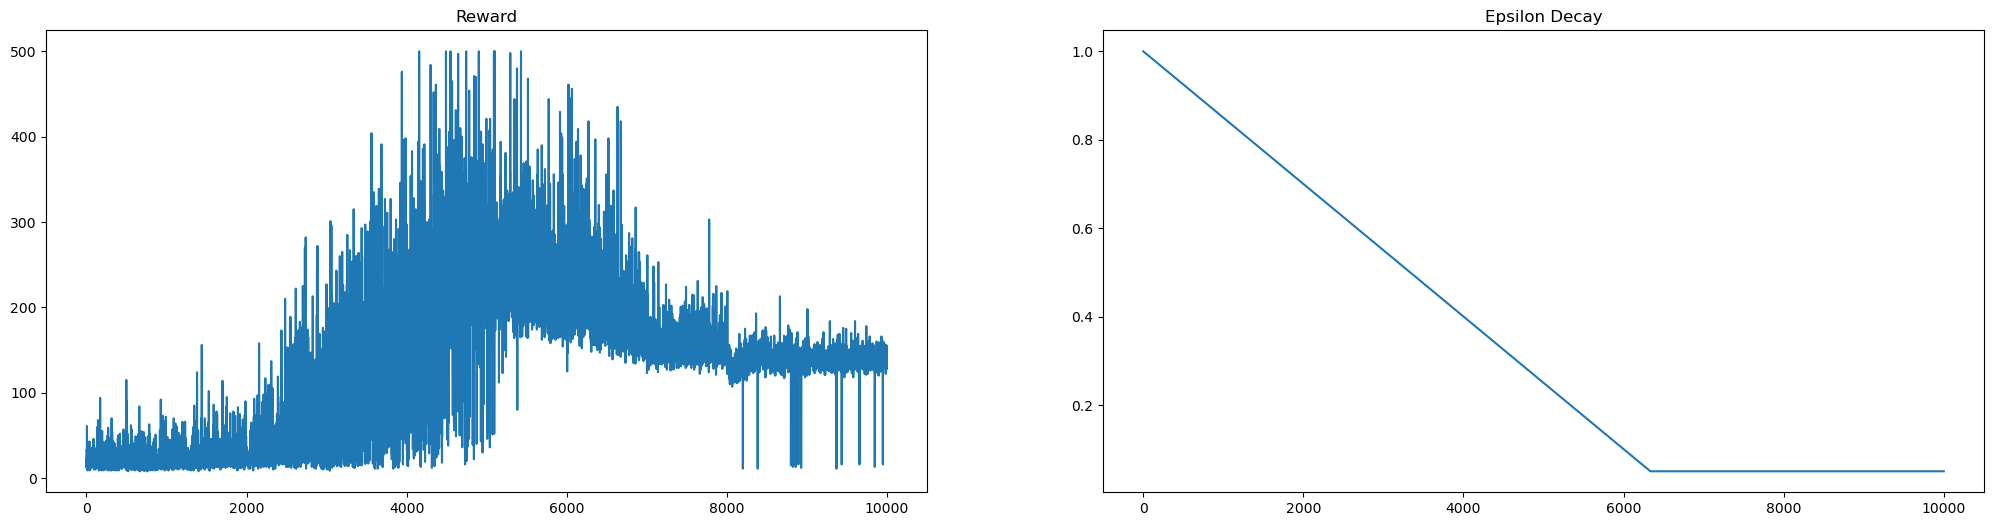

In [535]:

fig, axes = plt.subplots(1,2, figsize = (25,6))

#axes[0].plot(track_loss)
#axes[0].set_title('Loss')

axes[0].plot(track_reward)
axes[0].set_title('Reward')

#axes[2].plot(track_episode_len)
#axes[2].set_title('Episode Length')

axes[1].plot(track_epsilon)
axes[1].set_title('Epsilon Decay')

plt.show()

#### Part 2: Solved with Neurocontrol Strategy

2) Evolve a neural network to solve the previous task.

    What will you use for your evaluation function?

    What mapping should the network learn?

In [ ]:
# Define Agent, which uses q-network that can be modified easily as part of mutation

class NeuroCont_CartPole_Agent:

    """Generate new DQN_CartPole_Agent in environment env, with training params"""
    """Also initializes q_network"""
    def __init__(
                self,
                env,
                hidden_dim=64
            ):
        
        self.env = env
        self.fitness = 0
        self.time = 0

        # == NN Setup ==
       
        # initialize NN
        # q_network takes in a state as input and returns list of Q vals for all actions available from that state
        self.q_network = nn.Sequential(
            nn.Linear(in_features=self.env.observation_space.shape[0], out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            #nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=self.env.action_space.n)
        )

        self.q_network.apply(self.init_weights)

    """ Initialize the weights with random values """
    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    """ Returns the best action with probability (1 - epsilon), otherwise return random action """
    def get_action(self, obs) -> int:
        with torch.no_grad():
            Q_vals = self.q_network(torch.tensor(obs).float())
        Q_max, action = torch.max(Q_vals, dim=0)
        return action.item()

    """Assign fitness value corresponding to agent's performance"""
    def assign_fitness(self, fitness):
        self.fitness = fitness

    """Get assigned fitness val"""
    def get_fitness(self):
        return self.fitness

    """Assign time value corresponding to agent's performance"""
    def assign_time(self, time):
        self.time = time

    """Get assigned time val"""
    def get_time(self):
        return self.time

In [500]:
"""Perform mutation on network parameters
Mutation strategies from: https://stackoverflow.com/questions/31708478/how-to-evolve-weights-of-a-neural-network-in-neuroevolution"""
def mutate_network(agent: NeuroCont_CartPole_Agent):
    mut_agent = copy.deepcopy(agent)
    q_network = mut_agent.q_network
    
    # randomly select mutation type
    mutation = random.sample([0,1,2,3,4], 1)[0] 

    # Apply mutation
    with torch.no_grad():
        # Randomly select layer
        layer = random.randrange(0, 5, 2) # select Linear layer (ReLU layers not options)

        # select portion of neurons from layer to operate on
        ct = random.randint(0, int(q_network[layer].out_features / 2))

        for _ in range(ct):
            # Select random weight
            in_size = q_network[layer].in_features
            out_size = q_network[layer].out_features
            weight_in = random.randint(0, in_size-1)
            weight_out = random.randint(0, out_size-1)

            old_val = q_network[layer].weight[weight_out, weight_in]

            if mutation == 0: # replace weight with new random value
                new_val = random.uniform(-1,1) # between -1 and 1
            elif mutation == 1: # change weight by some percentage (0.5 to 1.5)
                new_val = old_val*round(random.uniform(0.5,1.5), 3)
            elif mutation == 2: # subtract random number between 0 and 1 from weight
                new_val = old_val - random.random()
            elif mutation == 3: # flip sign of weight
                new_val = old_val * -1
            elif mutation == 4: # select additional weight from neuron & swap with this one
                other_out = random.randint(0, out_size-1)
                new_val = q_network[layer].weight[other_out, weight_in]
                q_network[layer].weight[other_out, weight_in] = old_val

            q_network[layer].weight[weight_out, weight_in] = new_val # weight[outsize, insize]
        
    return mut_agent

"""Perform crossover between two parent networks, return two children. Using same resource as mutation"""
def do_crossover(parent1: NeuroCont_CartPole_Agent, parent2: NeuroCont_CartPole_Agent):
    crossover = random.sample([0,1,2,3,4,5,6,7], 1)[0]

    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    with torch.no_grad():

        parent1_net = parent1.q_network
        parent2_net = parent2.q_network
        child1_net = child1.q_network
        child2_net = child2.q_network
    
        if crossover == 0:
            """Swap an entire layer's weights. So given parents A and B, choose a particular layer (the same layer in both) 
            and swap all the weights between them to produce two offsping. This is a large move so we set it up so that this 
            operation would be selected less often than the others."""
            layer = random.randrange(0, 7, 2) # select Linear layer (ReLU layers not options)
        
            p1_layer = parent1_net[layer]
            p2_layer = parent2_net[layer]

            child1_net[layer] = p2_layer
            child2_net[layer] = p1_layer

        else: 
            """Swap either single weights or all weights for a given neuron in the network. So for example, given two parents 
            selected for reproduction either choose a particular weight in the network and swap the value, or choose a particular 
            neuron in the network and swap all the weights for that neuron to produce two offspring."""

            layer = random.randrange(0, 7, 2) # select Linear layer (ReLU layers not options)

            p1_layer = parent1_net[layer]
            p2_layer = parent2_net[layer]

            L_size = p1_layer.out_features
            weight_idx = random.randint(0, L_size-1)

            p1_weight = p1_layer.weight[weight_idx]
            p2_weight = p2_layer.weight[weight_idx]

            child1_net[layer].weight[weight_idx] = p2_weight
            child2_net[layer].weight[weight_idx] = p1_weight

    return child1, child2

"""Helper function for selecting from population"""
def selectOne(population, alpha=1):
    max = sum([a.get_fitness()**alpha for a in population])
    selection_probs = [a.get_fitness()**alpha/max for a in population]
    return population[np.random.choice(len(population), p=selection_probs)]

Training

In [517]:
"""Evolutionary algorithm for training neurocontroller"""

# Parameters
EPISODES = 500 # number of training episodes
k = 32 # number of agents (networks) in population
sim_cycles = 8 # number simulation cycles to run to evaluate fitness
hidden_dim = 16

env = gym.make('CartPole-v1')

# === Training ===

# Initialize a population of k Neurcontrol_Agents
population = []
for a in range(k):
    population.append(NeuroCont_CartPole_Agent(env,hidden_dim))

# Init fitnesses
for agent in population:

    total_reward = 0
    agent_sim_times_total = 0

    # run many simulation cycles
    for j in range(sim_cycles):

        # perform simulation
        obs, info = env.reset()
        done = False
        truncated = False
        sim_reward = 0
        sim_time = 0
        while not done and not truncated:

            action = dqn_agent.get_action(obs)
            obs_next, reward, done, truncated, info = env.step(action)

            sim_reward += reward
            sim_time += reward
            if truncated: sim_reward += 50 # Bonus reward if reached timeout
        # end simulation

        total_reward += sim_reward
        agent_sim_times_total += sim_time

    # process simulation data
    average_reward = total_reward / sim_cycles
    agent_avg_time = agent_sim_times_total / sim_cycles # add average time performance of agent
    # update agent fitness
    agent.assign_fitness(average_reward)
    agent.assign_time(agent_avg_time)

# Performance trackers
population_fitness = [] # tracks sum of average reward gained from all agents in population
performance_tracking = [] # tracks average performace of population (sum of (avg agent performance over sims / total sims) for all agents) / no. agents
best_times = [] # tracks best performance of any solution in each population

# for each training episode
for i in tqdm(range(EPISODES)):
    
    # == Generate Successors & Mutate ==
    # for each Neurcontrol_Agents, create a copy and perform some mutation to the copy
    while len(population) < 2*k:
        # Select from the best parents in the population
        parent1 = selectOne(population, 2)
        parent2 = selectOne(population, 2)
        operator = random.randint(0,10)
        if operator == 0: # just do asexual mutation
            mut_parent1 = mutate_network(parent1)
            mut_parent2 = mutate_network(parent2)
            mut_parent1.assign_fitness(0)
            mut_parent2.assign_fitness(0)
            population.append(mut_parent1)
            population.append(mut_parent2)
        else: # or else do crossover
            child1, child2 = do_crossover(parent1, parent2)
            mut_child1 = mutate_network(child1)
            mut_child2 = mutate_network(child2)
            mut_child1.assign_fitness(0)
            mut_child2.assign_fitness(0)
            population.append(mut_child1)
            population.append(mut_child2)

    # == Evaluate ==
    # for each Neurcontrol_Agent, perform simulation n times & sum all rewards (rewards are fitness)
    average_reward = 0 # fitness of agent
    agent_avg_time = 0 # sum of average times of all agents
    
    for agent in population:
        if agent.get_fitness() != 0: 
            continue # skip fitness eval for agents that have already been tested

        total_reward = 0
        agent_sim_times_total = 0

        # run many simulation cycles
        for j in range(sim_cycles):

            # perform simulation
            obs, info = env.reset()
            done = False
            truncated = False
            sim_reward = 0
            sim_time = 0
            while not done and not truncated:

                action = dqn_agent.get_action(obs)
                obs_next, reward, done, truncated, info = env.step(action)

                sim_reward += reward
                sim_time += reward
                if truncated: sim_reward += 50 # Bonus reward if reached timeout
            # end simulation

            total_reward += sim_reward
            agent_sim_times_total += sim_time

        # process simulation data
        average_reward = total_reward / sim_cycles
        agent_avg_time = agent_sim_times_total / sim_cycles # add average time performance of agent
        # update agent fitness
        agent.assign_fitness(average_reward)
        agent.assign_time(agent_avg_time)

    # Get fitness & time sum (pop size 2k)
    fitness_sum = 0 # over 2k elements
    time_sum = 0 # over 2k elements
    for agent in population:
        fitness_sum += agent.get_fitness()
        time_sum += agent.get_time()

    # == Select ==
    # Roulette wheel selection
    new_population = []

    # maintain best-performing solution
    best = max(a.get_time() for a in population)
    for a in population:
        if a.get_time() == best: new_population.append(a)


    while len(new_population) < k: # decreases pop size to k
        a = selectOne(population, 8)
        if a not in new_population:
            new_population.append(a)

    # Update population
    population = new_population

    # Update tracking info
    population_fitness.append(fitness_sum / (2*k))
    pop_avg_times = time_sum / (2*k) # average performane of agents in population
    performance_tracking.append(pop_avg_times)
    best_times.append(best)

    if i % (EPISODES / 10) == 0:
        print(f'EPISODE {i} AVG PERFORMANCE: {pop_avg_times} | BEST TIME: {best}')

    # == Repeat ==


  0%|          | 1/500 [00:00<03:34,  2.32it/s]

EPISODE 0 AVG PERFORMANCE: 22.158203125 | BEST TIME: 32.625


 10%|█         | 51/500 [00:16<02:30,  2.98it/s]

EPISODE 50 AVG PERFORMANCE: 26.30859375 | BEST TIME: 38.25


 20%|██        | 101/500 [00:32<01:47,  3.71it/s]

EPISODE 100 AVG PERFORMANCE: 27.041015625 | BEST TIME: 46.0


 30%|███       | 151/500 [00:51<02:03,  2.82it/s]

EPISODE 150 AVG PERFORMANCE: 27.6953125 | BEST TIME: 46.0


 40%|████      | 201/500 [01:07<01:35,  3.14it/s]

EPISODE 200 AVG PERFORMANCE: 27.650390625 | BEST TIME: 46.0


 50%|█████     | 251/500 [01:25<01:28,  2.82it/s]

EPISODE 250 AVG PERFORMANCE: 28.62890625 | BEST TIME: 46.0


 60%|██████    | 301/500 [01:42<01:07,  2.93it/s]

EPISODE 300 AVG PERFORMANCE: 28.646484375 | BEST TIME: 46.0


 70%|███████   | 351/500 [01:59<00:42,  3.51it/s]

EPISODE 350 AVG PERFORMANCE: 29.078125 | BEST TIME: 46.0


 80%|████████  | 401/500 [02:16<00:31,  3.17it/s]

EPISODE 400 AVG PERFORMANCE: 29.34765625 | BEST TIME: 46.0


 90%|█████████ | 451/500 [02:32<00:16,  3.01it/s]

EPISODE 450 AVG PERFORMANCE: 29.482421875 | BEST TIME: 46.0


100%|██████████| 500/500 [02:49<00:00,  2.96it/s]


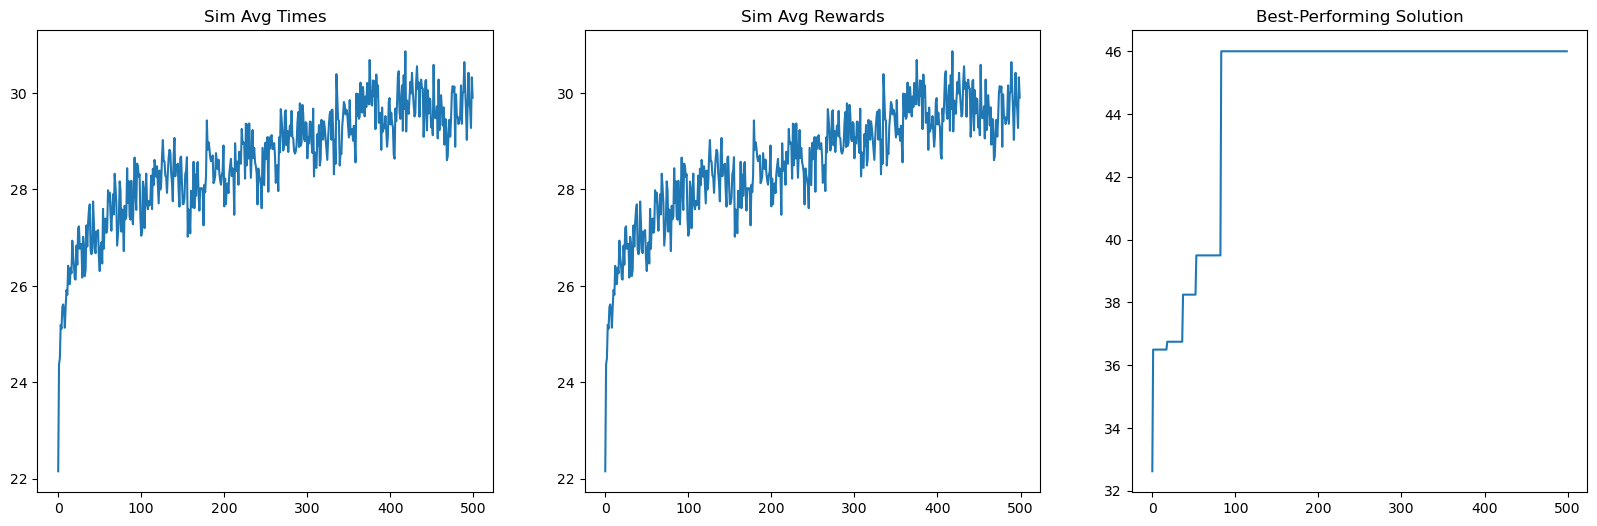

In [518]:
# == Displey Results ==
fig, axes = plt.subplots(1,3, figsize = (20,6))

axes[0].plot(performance_tracking)
axes[0].set_title('Sim Avg Times')

axes[1].plot(population_fitness)
axes[1].set_title('Sim Avg Rewards')

axes[2].plot(best_times)
axes[2].set_title('Best-Performing Solution')

plt.show()